# Exercise 7: Sensitivity and Parameter Identification

Libraries

In [1]:
%pip install -q matplotlib numpy odeintw pandas requests sammhelper scipy tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sammhelper as sh
import scipy as sp

Note: you may need to restart the kernel to use updated packages.


## Part I: Experiment in a batch reactor

You perform an experiment in a batch reactor. Compound A is degraded in a first order reaction
and you measure the concentrations indicated in Table 1 below.

<center><strong>Table 1:</strong> Measured concentration of compound A in the batch reactor (also provided in the file <em>Ex07.Data.txt</em>).</center>

| Time [min]  | $\bm{C_A}$ [g/m$\bm{^3}$] |
|:-----------:|:-------------------------:|
|           1 |                       137 |
|           5 |                       101 |
|           8 |                        81 |
|          10 |                        72 |
|          16 |                        51 |
|          20 |                        43 |
|          24 |                        36 |
|          30 |                        27 |

a) Find an analytical solution for the development of the concentration $C_A$ over time and name the parameters of your model.

b) Implement the analytical model in Excel and identify the parameters by minimizing the sum of squares by means of the <em>Solver</em> routine (see Chapter 3.7 in the Tutorial).

c) Implement your model in Python using the mass balance equation, not the analytical solution. Import the data (<em>Ex07.Data.txt</em>) and identify the parameters in Python (with a curve fit).

The overview of the dataset:
    time   CA
0     1  137
1     5  101
2     8   81
3    10   72
4    16   51
5    20   43
6    24   36
7    30   27
Original vs fitted average values: [0.05, 300] [6.14252324e-02 1.40180852e+02]
Standard deviation of estimated parameters: [3.25142430e-03 4.06483607e+00]


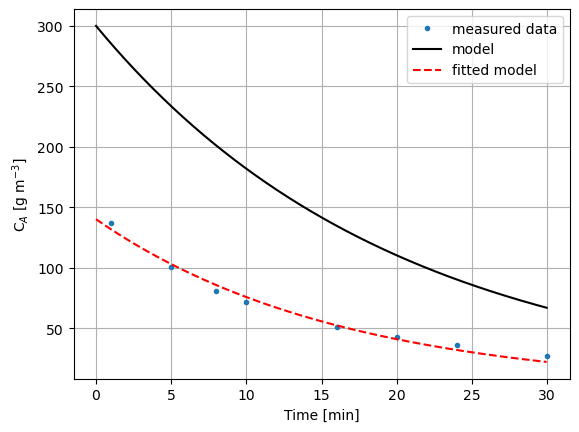

In [2]:
# Data Import
data = sh.data_import('Ex07.Data.txt', ['time', 'CA'])

# Parameters: Time
STARTTIME = 0   # [min]
STOPTIME = 30   # [min]
DT = 0.02       # [min]

# Time span
time = np.arange(STARTTIME, STOPTIME, DT)

# Parameters: Process
k = 0.05      # [min-1]
CA_0 = 300    # [g m-3]

# Parameters: Initial
def var0(param_var0):
    CA_0 = param_var0
    
    initCA = CA_0
    return initCA

# Define ODE
def model(var, t, param):
    CA = var
    k = param
    
    dCAdt = -k*CA
    return dCAdt

# Curve fit ODE
avg, cov = sh.curve_fit_ode(model, var0, time, xdata=data.time, ydata=data.CA, param=[k], param_var0 = [CA_0],  guess0=[k, CA_0])

plt.figure('curve fit')
plt.xlabel('Time [min]')
plt.ylabel('C$_A$ [g m$^{-3}$]')
plt.show()

# Calculating concentration of substance A with adjusted k and CA
k, CA_0 = avg
C = sh.sol_ode(model,var0(CA_0),time,k)

d) Determine the absolute-relative sensitivity functions with Python (see Chapter 3.7 in the Tutorial). Do you think that the parameter values can be uniquely identified from the data available?

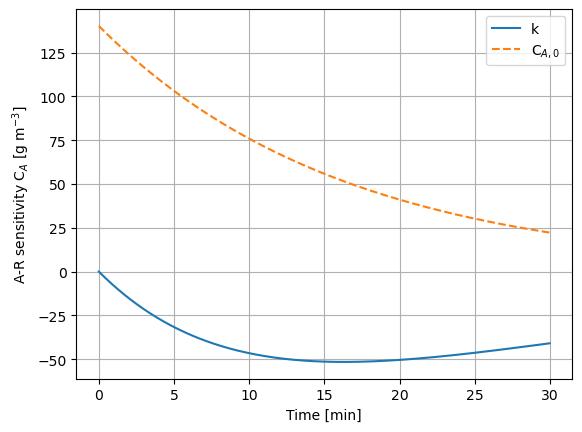

In [3]:
# Absolute-relative sensitivity
k_sens = sh.sensitivity(k,'time', model, var0, time, [k], [CA_0], linestyle='solid')
CA_0sens = sh.sensitivity(CA_0, 'time', model, var0, time, [k], [CA_0], linestyle='dashed')

# Plot
plt.figure('sensitivity')
plt.legend(['k', 'C$_{A,0}$'])
plt.ylabel('A-R sensitivity C$_A$ [g m$^{-3}$]')
plt.xlabel('Time [min]')
plt.grid()
plt.show()

# Calculate the standard deviations for each variable
std = np.sqrt(np.diag(cov))

# Calculate the correlation matrix (see also Gujer, p. 286ff)
corr = cov / np.outer(std, std)
corr[cov == 0] = 0 # Handle any numerical errors that might have occurred in division

e) Are there structural problems in this model? Would another reaction order provide a better fit to the data?

/opt/conda/lib/python3.11/site-packages/odeintw/_odeintw.py:275: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  result = odeint(func2, y0.view(np.float64), t, Dfun=jacfunc2, **kwargs)


Original vs fitted average values: [0.06142523239871907, 1, 140.18085202013597] [7.16084674e-03 1.50131905e+00 1.49442314e+02]
Standard deviation of estimated parameters: [0.00114533 0.03671773 1.0280985 ]


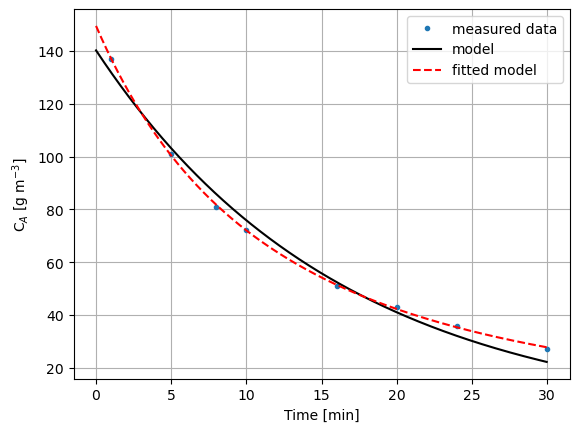

In [4]:
# Parameters: Process
n = 1       # reaction order

# Parameters: Initial
def var0(param_var0):
    CA_0 = param_var0
    
    initCA = CA_0
    return initCA

# Define ODE
def model(var, t, param):
    CA = var
    k, n = param
    
    dCAdt = -k*(CA**n)
    return dCAdt

# Solve ODE
avg, cov = sh.curve_fit_ode(model, var0, time, xdata=data.time, ydata=data.CA, param=[k, n], param_var0 = [CA_0],  guess0=[k, n, CA_0])

k, n, CA_0 = avg

plt.figure('curve fit')
plt.xlabel('Time [min]')
plt.ylabel('C$_A$ [g m$^{-3}$]')
plt.show()

### Additional questions to part I

f) Derive the absolute-relative sensitivity functions (in an analytical and numerical form) for all parameters.

## Part II: Modeling a river (Optional)

In a 10 km long straightened river, a step has been built every 500 m to stabilize the sediment. These steps prevent the back-mixing of water and material. The river is characterized as follows:
| Variable   | Value | Unit    | Description         |
|:----------:|------:|:-------:|---------------------|
|     Q =    |     4 | m$^3$/s | constant flow rate  |
|     h =    |   0.5 |    m    | average water depth |
|     B =    |    10 |    m    | average river width |

The following processes are of importance in the river (the algae grow as a biofilm on the sediment):
| Process        | Dissolved oxygen $\bm{S_{O2}}$ [g$\bm{_{O2}}$/m$\bm{^3}$] | Process rate $\bm{\rho}$ [g$\bm{_{O2}}$/m$\bm{^3}$/d]          |
|----------------|-------------------------------------------:|-------------------------------------------------|
| Photosynthesis |                                         +1 | $K_P \cdot I/h$                                 |
| Respiration    |                                         -1 | $K_R/h$                                         |
| Re-aeration    |                                         +1 | $K_B \cdot (S_{O2,sat}-S_{O2})\cdot 1/h$        |

With: 
| Variable       | Value                                         | Unit           | Description                                      |
|----------------|----------------------------------------------:|:--------------:|:-------------------------------------------------|
| $K_P =$        |                                           0.1 | g$_{O2}$/W/d   | oxygen release per watt-days of light energy     |
| $I =$          |  $I_{max} \cdot -cos(2 \cdot \pi \cdot t)$ | W/m$^2$        | available light energy (> 0), t in [d]           |
| $I_{max} =$    |                                          1200 | W/m$^2$        | maximum light intensity at midday                |
| $K_R =$        |                                            40 | 1/m$^2$/d      | respiration rate of the algae                    |
| $K_B =$        |                                            25 | m/d            | reaeration constant of the river including steps |
| $S_{O2,sat} =$ |                                            10 | g$_{O2}$/m$^3$ | saturation concentration for oxygen              |


g) Simulate the oxygen concentration in the diurnal variation (i) at the end of the flow distance and (ii) as a length profile in the river, at different ”points in time” with Python.

Hints:
- Model the individual stretches between two steps as CSTRs.
- You may assume $S_{O2,in}$ = 5 g$_{O2}$/m$^{3}$.
- The available light energy goes down to zero during the night, but can never be below zero. See Chapter 3.7 in the Tutorial for hints on how to model this limitation.
- Hints for the visualization in Python can be found in Chapter 3.7 in the Tutorial.

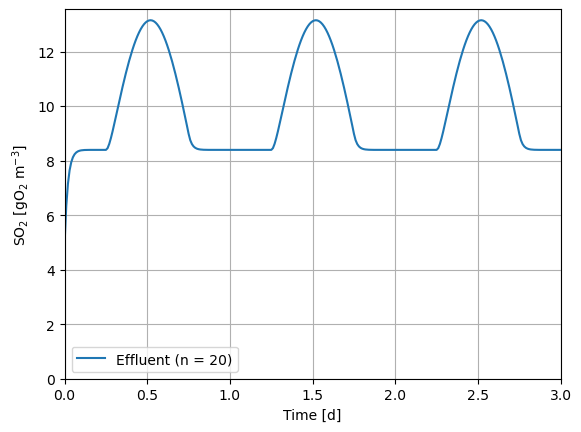

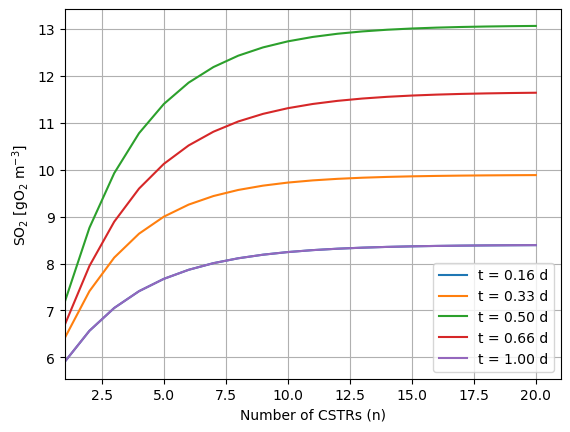

In [5]:
# Parameters: Time
STARTTIME = 0    # [d]
STOPTIME = 4     # [d]
DT = 0.01        # [d]

# Time span
time = np.arange(STARTTIME, STOPTIME, DT)

# Parameters: Process
Q = 4*3600*24       # [m3 d-1]
h = 0.5             # [m]
B = 10              # [m]
L = 500             # [m]
Ltot = 10000        # [m]

KP = 0.1            # [gO2 W-1 d-1]
Imax = 1200         # [W m-2]
KR = 40             # [gO2 m-2 d-1]
KB = 25             # [m d-1]
SO2_sat = 10        # [gO2 m-3]
SO2_in = 5          # [gO2 m-3]

n = int(Ltot/L)
V = L*B*h

# Parameters: Initial condition
initSO2 = np.zeros(n)
initSO2[0:n] = 5    # [gO2 m-3]

# Define ODE
def model(var, t, param):

    SO2 = var
    SO2_in, SO2_sat, Q, V, KP, KR, KB, Imax, h, n = param

    I = Imax * (-np.cos(2*np.pi*t))
    I = sh.limit(I, 0)

    dSO2dt = list(range(n))
    dSO2dt[0] = Q/V*(SO2_in - SO2[0]) + 1 * KP*I/h - \
    1 * KR/h + 1 * KB*(SO2_sat - SO2[0])/h
    dSO2dt[1:n] = Q/V*(SO2[0:n-1]-SO2[1:n]) + 1 * KP*I/h - \
    1 * KR/h + 1 * KB*(SO2_sat - SO2[1:n])/h
    return dSO2dt

# Solve ODE
SO2 = sh.sol_ode(model, var0=initSO2, t=time, param=[
                SO2_in, SO2_sat, Q, V, KP, KR, KB, Imax, h, n])

plt.figure('Effluent concentration')
plt.grid()
plt.plot(time, SO2[-1])                                          # Plots concentrations at the end of the flow distance= last stretch of river= last CSTR
plt.legend(['Effluent (n = 20)'])
plt.xlabel('Time [d]')
plt.ylabel('SO$_2$ [gO$_2$ m$^{-3}$]')
plt.xlim(xmin=0, xmax = 3)
plt.ylim(ymin=0)
plt.show()

plt.figure('Length profiles')
plt.grid()
plt.plot(range(1,n+1), [arr[15] for arr in SO2], range(1,n+1), [arr[32] for arr in SO2], range(1,n+1), [arr[49] for arr in SO2], range(1,n+1), [arr[65] for arr in SO2], range(1,n+1), [arr[99] for arr in SO2])         
plt.legend(['t = 0.16 d', 't = 0.33 d', 't = 0.50 d', 't = 0.66 d', 't = 1.00 d'])
plt.xlabel('Number of CSTRs (n)')
plt.ylabel('SO$_2$ [gO$_2$ m$^{-3}$]')
plt.xlim(xmin=1, xmax=n+1)
plt.show()

h) Identify the model parameters and determine the absolute-relative sensitivity of the effluent oxygen concentration $S_{O2,eff}$ relative to these model parameters (exclude the geometric parameters L, B, h, Q) in Python.

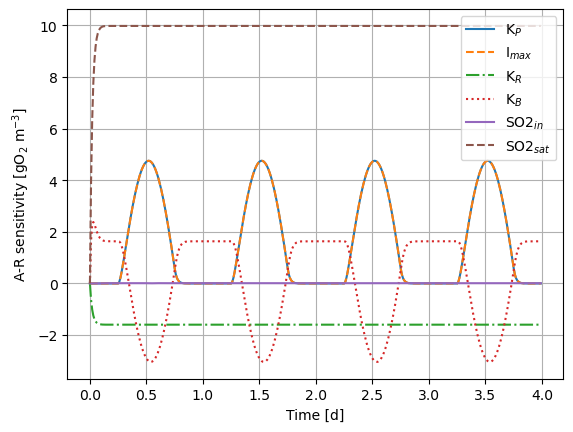

In [6]:
# Sensitivity
KP_sens = sh.sensitivity(KP, 'time', model, var0=initSO2, t=time, param=[SO2_in, SO2_sat, Q, V, KP, KR, KB, Imax, h, n], linestyle='solid')
Imax_sens = sh.sensitivity(Imax, 'time', model, var0=initSO2, t=time, param=[SO2_in, SO2_sat, Q, V, KP, KR, KB, Imax, h, n], linestyle='dashed')
KR_sens = sh.sensitivity(KR, 'time', model, var0=initSO2, t=time, param=[SO2_in, SO2_sat, Q, V, KP, KR, KB, Imax, h, n], linestyle='dashdot')
KB_sens = sh.sensitivity(KB, 'time', model, var0=initSO2, t=time, param=[SO2_in, SO2_sat, Q, V, KP, KR, KB, Imax, h, n], linestyle='dotted')
SO2in_sens = sh.sensitivity(SO2_in, 'time', model, var0=initSO2, t=time, param=[SO2_in, SO2_sat, Q, V, KP, KR, KB, Imax, h, n], linestyle='solid')
SO2sat_sens = sh.sensitivity(SO2_sat, 'time', model, var0=initSO2, t=time,  param=[SO2_in, SO2_sat, Q, V, KP, KR, KB, Imax, h, n], linestyle='dashed')

# plot the legend
plt.figure('sensitivity')
plt.legend(['K$_P$', 'I$_{max}$', 'K$_R$', 'K$_B$',
           'SO2$_{in}$', 'SO2$_{sat}$'], loc='upper right')
plt.xlabel('Time [d]')
plt.ylabel('A-R sensitivity [gO$_2$ m$^{-3}$]')
plt.grid()
plt.show()

# Sensitivity matrix
sens = np.array([
    KP_sens, 
    Imax_sens, 
    KR_sens, 
    KB_sens,
    SO2in_sens, 
    SO2sat_sens
    ])

# Correlation matrix
corr = np.corrcoef(sens, rowvar='False')

i) Discuss which parameters of the model can be uniquely determined from a continuously measured concentration curve of the dissolved oxygen in the effluent of the river.

j) Discuss the influence of the upper boundary condition of $S_{O2}$ on the discharge concentration of oxygen (i.e., influence of $S_{O2,in}$). How does its absolute-relative sensitivity function look over (i) the simulation time and (ii) the length profile? Lastly, simulate the length profile of its sensitivity function for varying $S_{O2,in}$ values.

Hint: For visualizing effects of different $S_{O2,in}$ in a single plot, see Chapter 3.7 in the Tutorial.

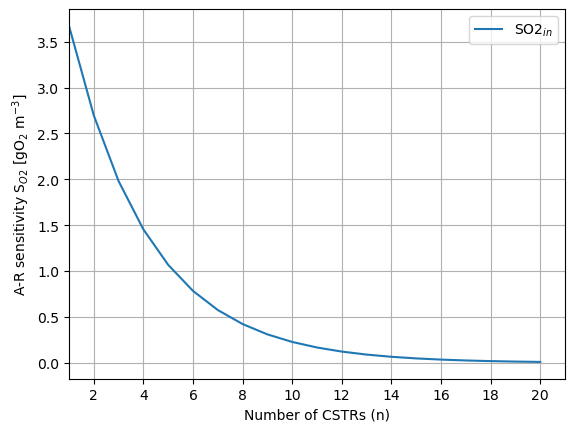

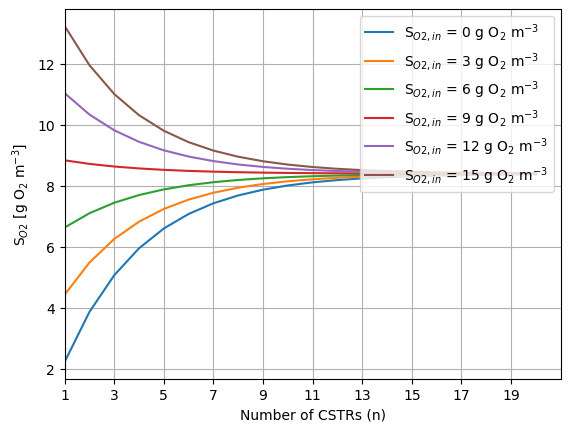

<Figure size 640x480 with 0 Axes>

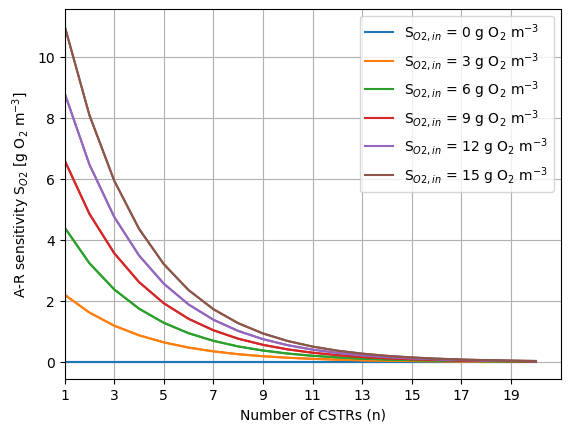

In [7]:
# Sensitivity of SO2_in over length
SO2in_sens = sh.sensitivity(SO2_in, 'length', model, var0=initSO2, t=time, param=[
                            SO2_in, SO2_sat, Q, V, KP, KR, KB, Imax, h, n])

# plot the legend
plt.figure('sensitivity')
plt.legend(['SO2$_{in}$'])
plt.ylabel('A-R sensitivity S$_{O2}$ [gO$_2$ m$^{-3}$]')
plt.xlabel('Number of CSTRs (n)')
plt.grid()
plt.show()

# Different SO2_in
SO2_in = list(range(0, 16, 3))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

plt.figure('concentration')
count = 0
for i in SO2_in:
    SO2 = sh.sol_ode(model, var0=initSO2, t=time, param=[i, SO2_sat, Q, V, KP, KR, KB, Imax, h, n])
    plt.plot(range(1, n+1), [arr[-1] for arr in SO2], label=f'S$_{{O2,in}}$ = {i} g O$_2$ m$^{{-3}}$', color=colors[count])
    count += 1
plt.legend(loc='upper right')
plt.xlabel('Number of CSTRs (n)')
plt.ylabel('S$_{O2}$ [g O$_2$ m$^{-3}$]')
plt.xlim(xmin=1, xmax=n+1)
plt.xticks(range(1, n+1, 2))
plt.grid()
plt.show()

plt.figure('sensitivityBC')
count = 0
for i in SO2_in:
    SO2in_sens = sh.sensitivity(i, 'length', model, var0=initSO2, t=time, param=[i, SO2_sat, Q, V, KP, KR, KB, Imax, h, n])
    plt.plot(range(1, n+1), SO2in_sens, label=f'S$_{{O2,in}}$ = {i} g O$_2$ m$^{{-3}}$', color=colors[count])
    count += 1
plt.legend(loc='upper right')
plt.xlabel('Number of CSTRs (n)')
plt.ylabel('A-R sensitivity S$_{O2}$ [g O$_2$ m$^{-3}$]')
plt.xlim(xmin=1, xmax=n+1)
plt.xticks(range(1, n+1, 2))
plt.grid()
plt.show()